In [23]:
import mltrainer
assert mltrainer.__version__ >= "0.2.5"

In [24]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

from src import datasets, metrics
from mltrainer.transformer import print_cpu_memory_usage


In [25]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"

In [26]:
import tomllib

datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


Lets test the big dataset

In [27]:
trainfile = datadir / (config['arrhythmia'] + '_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

Load the data

In [28]:
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")
traindataset, testdataset

(Heartdataset (len 87554), Heartdataset (len 21892))

In [29]:
import torch

target_count = 15000
all_indices = []

labels = torch.unique(traindataset.y)

# ADRIAAN Print originele verdeling
print("Originele klassenverdeling:")
for label in labels:
    count = (traindataset.y == label).sum().item()
    print(f"  Klasse {label}: {count} samples")

for label in labels:
    class_indices = (traindataset.y == label).nonzero().squeeze()
    if len(class_indices.shape) == 0:
        class_indices = class_indices.unsqueeze(0)  # voor 1 sample

    current_count = len(class_indices)
    print(f"Klasse {label}: {current_count} → {target_count} samples")

    if current_count > target_count:
        # Downsampling
        selected = class_indices[torch.randperm(current_count)[:target_count]]
    elif current_count < target_count:  # ADRIAAN Expliciete elif voor duidelijkheid
        # Upsampling met replacement
        selected = class_indices[torch.randint(0, current_count, (target_count,))]
    else:
        # ADRIAAN Exact target_count: gebruik alle samples
        selected = class_indices

    all_indices.append(selected)

# Combineer en shuffle
all_indices = torch.cat(all_indices)
perm = torch.randperm(len(all_indices))
all_indices = all_indices[perm]

# Pas toe op dataset
traindataset.x = traindataset.x[all_indices]
traindataset.y = traindataset.y[all_indices]

# Controleer de nieuwe verdeling
print(f"\nNieuwe klassenverdeling: {torch.bincount(traindataset.y)}")
print(f"Totaal aantal samples: {len(traindataset.y)}")

# ADRIAAN Verificatie dat elke klasse precies 15000 samples heeft
for label in labels:
    count = (traindataset.y == label).sum().item()
    assert count == target_count, f"Klasse {label} heeft {count} samples, verwacht {target_count}"
print("✅ Alle klasses hebben precies 15000 samples!")


Originele klassenverdeling:
  Klasse 0: 72471 samples
  Klasse 1: 2223 samples
  Klasse 2: 5788 samples
  Klasse 3: 641 samples
  Klasse 4: 6431 samples
Klasse 0: 72471 → 15000 samples
Klasse 1: 2223 → 15000 samples
Klasse 2: 5788 → 15000 samples
Klasse 3: 641 → 15000 samples
Klasse 4: 6431 → 15000 samples

Nieuwe klassenverdeling: tensor([15000, 15000, 15000, 15000, 15000])
Totaal aantal samples: 75000
✅ Alle klasses hebben precies 15000 samples!


Visualise it as 1D data

torch.Size([192, 1]) tensor(0)


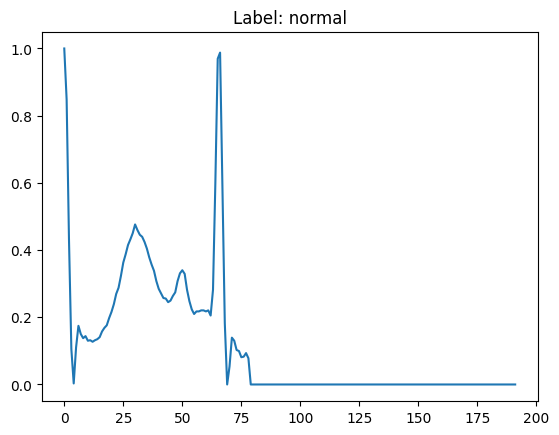

In [30]:
x, y = traindataset[0]
viz = x.squeeze().cpu().numpy()
sns.lineplot(x=range(len(viz)), y=viz)
title = 'normal' if y == 0 else 'abnormal'
plt.title(f"Label: {title}");
print(x.shape, y)

Set up the streamer

In [31]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(2343, 684)

In [32]:
print_cpu_memory_usage()

Current process memory usage: 1547.91 MB


We can import the transformer architecture from `mltrainer`, where i implemented a memory-efficient version of the transformer architecture.

In [33]:
from mltrainer.transformer import Transformer
from src.simple_cnn import SimpleCNN 

Note, the layers have different assumptions about the data structure:
- streamer:         (batch, seq_len, channels)
- conv1d:           (batch, channels, seq_len)
- pos_encoding:     (batch, seq_len, channels)
- gru (batchfirst): (batch, seq_len, channels)
- attention:        (batch, seq_len, channels)

As you can see, its only the conv1d layer that expects channels as the second dimension. Using a conv1d layer you
will need to transpose the dimensions, I show how to do that in the `mltrainer.transfomer.forward` method.

Again, the strategy of creating a block helps us stack the architecture more easily.
Lets start with a very basic config.

In [34]:
config = {
    'output': 5,      # 5 arrhythmia klassen
    'dropout': 0.3    # Pas aan naar wens
}

model = SimpleCNN(config)

Check if it works

In [35]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 192, 1]), torch.Size([32]))

Shapes look good

In [36]:
yhat = model(x)
yhat.shape

torch.Size([32, 5])

Lets test the metrics for the untrained model

In [37]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()
metrics_list = [f1micro, f1macro, precision, recall, accuracy]

In [38]:
for metric in metrics_list:
    print(f"{metric}:", metric(y, yhat))

F1Score_micro: 0.21875
F1Score_macro: 0.15454545454545454
Precision_micro: 0.21875
Recall_macro: 0.25999999999999995
Accuracy: 0.21875


And the memory

In [39]:
print_cpu_memory_usage()

Current process memory usage: 1548.17 MB


In [40]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam_1d_cnn.db")
mlflow.set_experiment("Simple CNN")

<Experiment: artifact_location='/home/azureuser/MADS-exam-25/notebooks_adriaan/mlruns/1', creation_time=1750339104006, experiment_id='1', last_update_time=1750339104006, lifecycle_stage='active', name='Simple CNN', tags={}>

We want to have feedback more often, so lets test metrics every 1/5th of the dataset

In [41]:
steps = len(trainstreamer) // 5
steps

468

In [42]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=20,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=steps,
        valid_steps=steps,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        device=device,
        )
    trainer.loop()

2025-06-19 13:32:30.356 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to logs/heart1D/20250619-133230
100%|██████████| 468/468 [00:23<00:00, 20.18it/s]
2025-06-19 13:33:02.695 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.5374 test 0.5957 metric ['0.8225', '0.8225', '0.5840', '0.8225', '0.8697']
100%|██████████| 468/468 [00:21<00:00, 21.32it/s]
2025-06-19 13:33:34.098 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.3381 test 0.3152 metric ['0.9360', '0.9360', '0.7453', '0.9360', '0.8700']
100%|██████████| 468/468 [00:22<00:00, 21.12it/s]
2025-06-19 13:34:05.527 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.2832 test 0.5909 metric ['0.7704', '0.7704', '0.5628', '0.7704', '0.8714']
100%|██████████| 468/468 [00:25<00:00, 18.66it/s]
2025-06-19 13:34:41.826 | INFO     | mltrainer.trainer:report:209 - Epoch 3 train 0.2580 test 0.2774 metric ['0.9038', '0.9038', '0.6954', '0.9038', '0.9118']
100%|██████████| 468/468 [00:25<00:00, 18.25it

In [43]:
print_cpu_memory_usage()

Current process memory usage: 1559.44 MB


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

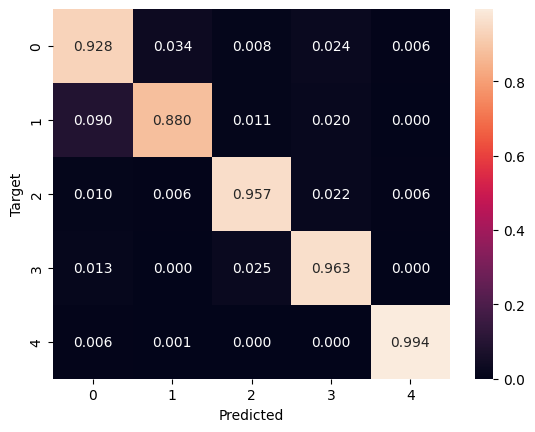

In [44]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
model.to("cpu")
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")